In [1]:
from functools import partial

import jax
import jax.numpy as np
import matplotlib.pyplot as plt

For some special cases, we can find an analytic solution.

In [46]:

# special case for analytic solution
tau_syn = 5e-3
tau_mem = 1e-2
assert tau_mem == 2 * tau_syn 

tau_mem_inv = 1 / tau_mem
tau_syn_inv = 1 / tau_syn

v_leak = 0.0
v_th = 0.4


def spike_time(weights, input_spikes):
    exp_spike_times_syn = np.exp(input_spikes / tau_syn)
    exp_spike_times_mem = np.exp(input_spikes / tau_mem)

    eps = 1e-6
    factor_a1 = np.matmul(weights, exp_spike_times_syn)  # + eps
    factor_a2 = np.matmul(weights, exp_spike_times_mem)
    factor_c = v_th - v_leak

    factor_sqrt = np.sqrt(factor_a2 ** 2 - 4 * factor_a1 * factor_c)

    ret_val = 2. * tau_syn * np.log(2. * factor_a1 / (factor_a2 + factor_sqrt))
    ret_val = np.where(np.isnan(ret_val), 2*tau_mem, ret_val)
    return ret_val

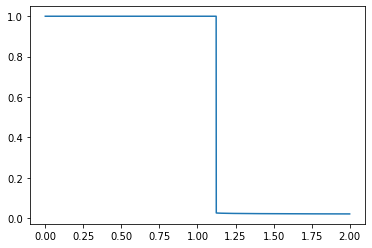

In [3]:
# how does the spike time depeneds on the weight?
st = partial(spike_time, input_spikes=np.array([tau_syn, 2*tau_mem]))

weights = np.arange(0.0, 2.0, 1e-4)
input = np.repeat(weights, 2).reshape(-1, 2)  # type: ignore
times = jax.vmap(st)(input)
# for i in input:
#     st(i)

plt.plot(weights, times)
plt.show()

In [4]:
def heaviside(x):
  return 0.5 + 0.5 * np.sign(x)

def kernel(A, t, t0):
  return heaviside(t - t0) * jax.scipy.linalg.expm(A * (t - t0))

def f(A, t0, x0, t):
  return np.einsum("ijk, ik -> j", jax.vmap(partial(kernel, A, t))(t0), x0)  # np.stack((np.zeros_like(x0), x0), axis=1))


Second input spike at voltage: 0.239 and current: 0.868
Spike time: 0.00703 at voltage: 0.4000000059604645


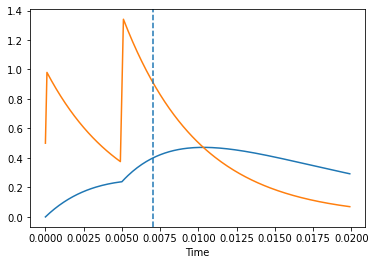

In [5]:
A = np.array([[-tau_mem_inv, tau_mem_inv], [0, -tau_syn_inv]])

tk = np.array([0., 5e-3])
xk = np.array([[0.0, 1.0], [0.0, 1.0]])

ts = np.arange(0.0, 0.02, 1e-4)
ys = jax.vmap(partial(f, A, tk, xk), in_axes=0)(ts)

t_spike = spike_time(xk[:,1], tk)  # type: ignore
gradient = jax.grad(spike_time)(xk[:, 1], tk)  # type: ignore

dynamics = partial(f, A, tk, xk)
print(f"Second input spike at voltage: {dynamics(tk[1:])[0]:.3f} and current: {dynamics(tk[1:])[1]:.3f}")
print(f"Spike time: {t_spike:.5f} at voltage: {partial(f, A, tk, xk)(t_spike)[0]}")
plt.xlabel('Time')
plt.plot(ts, ys)
plt.axvline(t_spike, linestyle='--')

We can replicate this with only the second spike if we also spike the voltage.

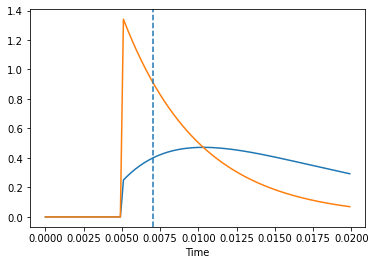

In [6]:
tk = np.array([5e-3])
xk = np.array([[0.239, 1.368]])

ys = jax.vmap(partial(f, A, tk, xk), in_axes=0)(ts)

# t_spike = spike_time(xk[:,1], tk, v_th)  # type: ignore

plt.xlabel('Time')
plt.plot(ts, ys)
plt.axvline(t_spike, linestyle='--')

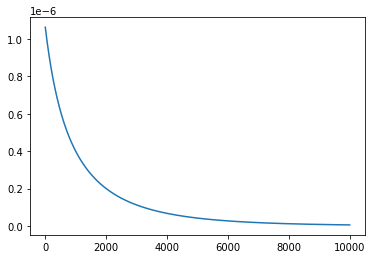

In [7]:
# define a loss function and train the neuron
def loss(weights, input_spikes, target):
    t_spike = spike_time(weights, tk)
    return (t_spike - target) ** 2

def update(weights, epoch, tk):
    value, grad = jax.value_and_grad(loss)(weights, tk, target)  # type: ignore
    weights = jax.tree_map(lambda f, df: f - lr * df, weights, grad)
    return weights, value

target = 0.006
lr = 10.0
tk = np.array([0., 5e-3])
weights = np.array([1.0, 1.0])
weights, loss_value = jax.lax.scan(partial(update, tk=tk), weights, np.arange(10000))
# %timeit jax.lax.scan(update, weights, np.arange(10000))
plt.plot(np.arange(10000), loss_value)
plt.show()

We already have two input spikes from two different weights. Now let's map this to two output neurons

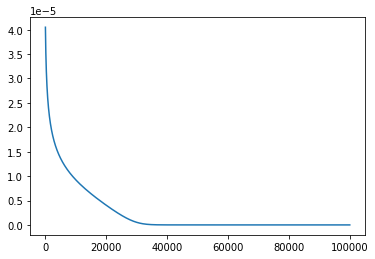

In [8]:
weights = np.array([[1.0, 1.0], [1.0, 1.0]])
n_epochs = 100_000
lr = 10.0

# define a new loss function
def loss(weights, batch):
    x, y = batch
    t_spike = spike_time(weights, x)
    return np.sum((t_spike - y) ** 2)

def update(weights, batch):
    value, grad = jax.value_and_grad(loss)(weights, batch)  # type: ignore
    weights = jax.tree_map(lambda f, df: f - lr * df, weights, grad)
    return weights, value

x = np.array([0., 5e-3])
y = np.array([0.001, 0.005])
input = (np.repeat(x[None,:], n_epochs, axis=0), np.repeat(y[None,:], n_epochs, axis=0))  # type: ignore
weights, loss_value = jax.lax.scan(update, weights, input)
plt.plot(np.arange(n_epochs), loss_value)
plt.show()

In [59]:
# now introduce a new loss function for ttfs
def loss_fn(t_spike, target):
    return np.sum((t_spike - target) **2)


def loss(weights, batch):
    x, y = batch
    t_spike = jax.vmap(spike_time, in_axes=(None, 0))(weights, x)
    return np.sum(jax.vmap(loss_fn, in_axes=(0, 0))(t_spike, y))

def acc(weights, batch):
    x, y = batch
    t_spike = jax.vmap(spike_time, in_axes=(None, 0))(weights, x)
    return np.sum(np.argmin(t_spike, axis=1) == np.argmin(y, axis=1)) / len(x)


# def loss_linear(weights, batch):
#     x, y = batch
#     # linear model
#     t_spike = np.matmul(x, weights)
#     return np.sum(jax.vmap(loss_fn, in_axes=(0, 0))(t_spike, y))

# def acc_linear(weights, batch):
#     x, y = batch
#     t_spike = np.matmul(x, weights)
#     return np.sum(np.argmin(t_spike, axis=1) == np.argmax(y, axis=1)) / len(x)

def update(weights, batch):
    value, grad = jax.value_and_grad(loss)(weights, batch)  # type: ignore
    grad = np.where(np.isnan(grad), -0.01, grad)
    weights = jax.tree_map(lambda f, df: f - lr * df, weights, grad)
    return weights, value

print(loss_fn(np.array([np.inf, np.inf]), np.array([0, 1])))
print(loss_fn(np.array([0.05, 0.9]), np.array([0, 1])))
print(loss_fn(np.array([0.001, 0.002]), np.array([0, 1])))


inf
0.012500005
0.99600506


Accuracy: 0.7846


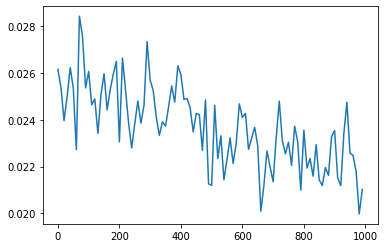

Non zero weight: 0
Non zero loss: 0


In [60]:
# create a circle dataset
def dataset(key, batch_size, n_samples):
    r = 1
    t_late = 3 * tau_syn
    x = jax.random.uniform(key, (n_samples, batch_size, 2))
    y = np.where(x[:,:,0] ** 2 + x[:,:,1] ** 2 > 1, 1, 0)
    one_hot = np.array([[0.0, tau_mem], [tau_mem, 0.0]])[y]  # type: ignore
    return x * t_late, one_hot

rng = jax.random.PRNGKey(42)
rng, tr_key = jax.random.split(rng)
batch_size = 128
x, y = dataset(rng, batch_size, 1000)
weights = np.array([[1.0, 1.0], [1.0, 1.0]])
lr = 0.01

weights, loss_value = jax.lax.scan(update, weights, (x, y))
accuracy = np.mean(jax.vmap(partial(acc, weights))((x, y)))
print(f"Accuracy: {accuracy:.4f}")

plt.plot(np.arange(len(x))[::10], loss_value[::10])
plt.show()
print(f"Non zero weight: {np.count_nonzero(np.isnan(weights))}")
print(f"Non zero loss: {np.count_nonzero(np.isnan(loss_value))}")


In [56]:
# now add a hidden layer, create a layer function
def apply_fn(weights, x):
    for w in weights:
        # TODO how can spike time be negative??
        x = spike_time(w, x)
    return x

# initialize weights
def init_weights(rng, layers):
    weights = []
    for _in, _out in zip(layers, layers[1:]):
        rng, weight_rng = jax.random.split(rng, 2)
        weights.append(jax.random.uniform(weight_rng, (_out, _in)) + 0.2)
    return weights

def loss(weights, batch):
    x, y = batch
    t_spike = jax.vmap(apply_fn, in_axes=(None, 0))(weights, x)
    return np.sum(jax.vmap(loss_fn, in_axes=(0, 0))(t_spike, y))


def acc(weights, batch):
    x, y = batch
    t_spike = jax.vmap(apply_fn, in_axes=(None, 0))(weights, x)
    return np.sum(np.argmin(t_spike, axis=1) == np.argmin(y, axis=1)) / len(x)


def update(weights, batch):
    value, grad = jax.value_and_grad(loss)(weights, batch)  # type: ignore
    weights = jax.tree_map(lambda f, df: f - lr * (np.where(np.isnan(df), -0.01, df)), weights, grad)  # type: ignore
    return weights, value

Accuracy: 0.7850
1.1993823 0.65382963


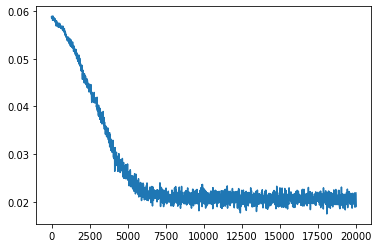

In [57]:
weights = init_weights(rng, (2, 50, 2))

x, y = dataset(rng, batch_size, 20_000)
weights, loss_value = jax.lax.scan(update, weights, (x, y))
accuracy = np.mean(jax.vmap(partial(acc, weights))((x, y)))
print(f"Accuracy: {accuracy:.4f}")
print(np.mean(weights[0]), np.mean(weights[1]))
plt.plot(np.arange(len(x))[::10], loss_value[::10])
plt.show()